jupyter notebook --NotebookApp.iopub_data_rate_limit=7368709120

In [1]:
# Reset memory

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# General Imports
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import Counter

# Imports for Model Evaluation
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, confusion_matrix

# Imports for Data Transformation
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.preprocessing import PowerTransformer

# Imports for Oversampling and Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Imports for Models
import mlflow
import xgboost
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Imports for LIME
import lime
import lime.lime_tabular


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# DATA IMPORT

In [3]:
df = pd.read_csv('C:/Users/td/implement_scoring_loan/notebook/data_cleaned.csv')

In [4]:
df.head(3)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [5]:
X=df.drop(['TARGET'],axis=1)

y=df['TARGET']

# Imbalanced Class

In [12]:
# summarize the class distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d -- Count=%d -- Percentage=%.3f%%' % (k, v, per))

Class=1 -- Count=24825 -- Percentage=8.073%
Class=0 -- Count=282682 -- Percentage=91.927%


In [13]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Équilibrage des données en utilisant SMOTE
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
sampling_pipeline = ImbPipeline(steps=steps)

# transform the dataset
X_train_resampled, y_train_resampled= sampling_pipeline.fit_resample(X_train, y_train)

In [14]:
y_train_resampled.value_counts()/len(y_train_resampled)

0.0    0.666667
1.0    0.333333
Name: TARGET, dtype: float64

# Features Selection

In [15]:
# Selection of the most important features
selector = SelectPercentile(score_func=f_classif, percentile=2)

In [16]:
# Feature Selection using  Selector
X_train_new = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_new = selector.transform(X_test)

c:\users\td\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 15 277 282 288 294 298 307 396 404 407 433 438 443 453 466 468 481 495
 501 505 514 526 532 626 627 745 750 760 761 762 763 764 770 775 780 790
 791 792 793 794] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\users\td\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


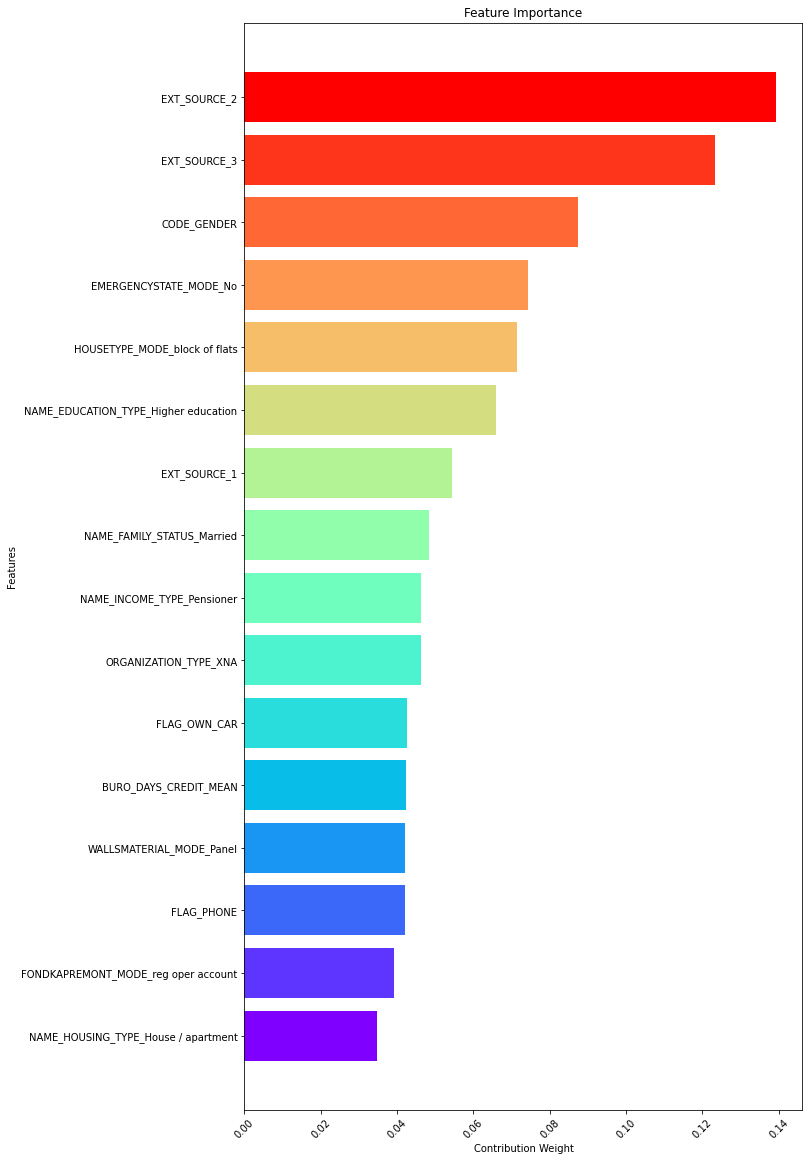

In [17]:
# Getting feature scores
scores = selector.scores_

# Getting feature names
feature_names = X.columns.values

# Getting a boolean array indicating the selected features
mask = selector.get_support()

# Getting names and scores of the selected features
selected_feature_names = feature_names[mask]
selected_scores = scores[mask]

# Sorting names and scores in descending order of contribution weight
sorted_indices = np.argsort(selected_scores)
sorted_feature_names = selected_feature_names[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Calculating contribution weights for each feature
weights = sorted_scores / np.sum(sorted_scores)

# Creating a rainbow-colored bar plot sorted by descending contribution weight
fig, ax = plt.subplots(figsize=(10, 20))
colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_feature_names)))
ax.barh(sorted_feature_names, weights, color=colors)
ax.set_xlabel('Contribution Weight')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

# Tilting variable names at a 45-degree angle
plt.xticks(rotation=45)

plt.show()


In [18]:
with open('C:/Users/td/implement_scoring_loan/dashboard/selected_feature_names.pkl', 'wb') as f:
    pickle.dump(selected_feature_names, f)

In [19]:
selected_feature_names.shape

(16,)

# Dummy

Before we can improve our model, we need a baseline.

In [20]:
clf_dummy = DummyClassifier(random_state=39) 
#establishing random_state for reproducibility
clf_dummy.fit(X_train,y_train)
y_pred = clf_dummy.predict(X_test)

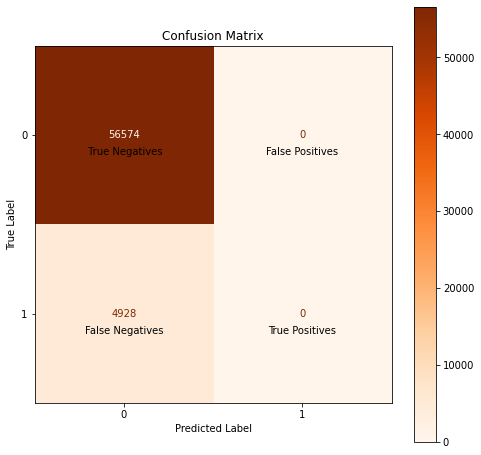

In [21]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créer un objet ConfusionMatrixDisplay avec la matrice de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Afficher la matrice de confusion avec des étiquettes
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='Oranges')

# Ajouter des étiquettes aux cellules de la matrice de confusion
ax.text(0, 0, '\n True Negatives', ha='center', va='top')
ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
ax.text(1, 1, '\nTrue Positives',ha='center', va='top')

# Ajouter un titre et des étiquettes d'axe
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

## MLFLOW UI

In [21]:
def score_metier(y_true,y_pred):
    cost_fn = 10 # Coût d'un FN est dix fois supérieur au coût d'un FP
    cost_fp = 1
    # Matrice de confusion pour calculer le nombre de FN et de FP
    confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_true == 0)), np.sum((y_pred == 1) & (y_true == 0))],
                                 [np.sum((y_pred == 0) & (y_true == 1)), np.sum((y_pred == 1) & (y_true == 1))]])
    score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]
    return score_metier

In [ ]:
selector = ColumnTransformer(
    transformers=[('select', 'passthrough', feature_names)],
    remainder='drop'
)

In [20]:
cv = StratifiedKFold(n_splits=5)

In [15]:

# Transform Features

preprocessor=PowerTransformer(method='yeo-johnson',standardize=True)

In [20]:
param_log_reg = {'model__penalty': ['l1', 'l2'],
                 'model__C': np.logspace(-4, 4, 20)}

param_knn = {'model__n_neighbors': [3, 5, 11],
             'model__weights': ['uniform', 'distance'],
             'model__algorithm': ['auto', 'ball_tree']}


param_svm = {'model__C': [0.1, 1, 10],
             'model__kernel': ['linear', 'poly'],
             'model__gamma': ['scale', 'auto']}

param_rf = {'model__n_estimators': [100, 200],
            'model__max_depth': [5, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2,],
            'model__max_features': ['auto', 'sqrt'],
            'model__bootstrap': [True, False]}

param_gbm = {'model__learning_rate': [0.1, 0.2],
             'model__n_estimators': [100, 200],
             'model__max_depth': [3, 4, 5]}

param_Xgboost = {'model__n_estimators': [50,100],
                 'model__max_depth': [3, 4],
                 'model__learning_rate': [0.01, 0.2]}

In [21]:
# Dictionnaire de classifieurs 
models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
           'KNN':{'model': KNeighborsClassifier(), 'params': param_knn},
           'Gradient Booster Classifier':{'model': GradientBoostingClassifier(), 'params': param_gbm},
            'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
              }

In [21]:
def train_model(model_name, model_params, preprocessor, cv):
    ## TODO IMBALANCED PIPE
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_name)])
    gscv = GridSearchCV(pipe, param_grid=model_params, cv=cv, scoring='accuracy', n_jobs=-1)
    gscv.fit(X_train_new, y_train_resampled)
    gscv_best = gscv.best_estimator_
#     for i, params in enumerate(gscv.cv_results_['params']):
    with mlflow.start_run(run_name=model):
#         mlflow.log_params(gscv_best.best_params)
        mlflow.log_params(gscv.best_params_)
        mlflow.sklearn.log_model(gscv_best, "modele_regression_logistique_without_preprocessor")
        probabilities = gscv_best.predict_proba(X_test_new)
        threshold = 0.7
        y_pred = np.where(probabilities[:, 1] >= threshold, 1, 0)
        mlflow.log_metric("score_auc", roc_auc_score(y_test, y_pred))

        mlflow.log_metric('score_metier', score_metier(y_test, y_pred))

In [ ]:
mlflow.set_experiment('Scoring_loan_classifier')
for model in models_.keys():
    train_model(models_[model]['model'],models_[model]['params'],preprocessor,cv)

In [26]:
import requests

# URL de la page web à télécharger
url = "http://127.0.0.1:5000/#/experiments/421796574728863656?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All%20Runs&selectedColumns=metrics.%60score_auc%60,metrics.%60score_metier%60&isComparingRuns=false"

# Envoi de la requête GET
response = requests.get(url)

# Vérification du code de statut HTTP
if response.status_code == 200:
    # Enregistrement de la page web en tant que fichier HTML
    with open("rapport_mlflow.html", "w") as f:
        f.write(response.text)
        print("La page web a été enregistrée avec succès.")
else:
    print(f"La requête a échoué avec le code de statut HTTP {response.status_code}.")


La page web a été enregistrée avec succès.


## STREAMLIT AND FASTAPI

In [18]:
# Features selection
selector = ColumnTransformer(
    transformers=[('select', 'passthrough', feature_names)],
    remainder='drop'
)

In [19]:
# Saving the selected model

model_saved=LogisticRegression()

In [20]:
pipeline = Pipeline(steps=[
    ('feature_selection', selector), 
    ('preprocessing', preprocessor), 
    ('model', model_saved)
])

In [52]:
# Fit model

pipeline.fit(X,y)

KeyboardInterrupt: 

In [51]:
# Saving model for fastapi

joblib.dump(pipeline, 'C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib')

['C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib']

## LIME : FEATURE LOCAL

In [39]:
# with open('C:/Users/td/implement_scoring_loan/api/selected_feature_names.pkl', 'wb') as f:
#     pickle.dump(selected_feature_names, f)

In [28]:
##TODO REMETTRE training_data=X_train_resampled[selected_feature_names].values

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X[selected_feature_names].values,
                                                   feature_names=selected_feature_names,
                                                   class_names=['0','1'],
                                                   discretize_continuous=True)

In [34]:
# Lime : local feature experience

# Saving model for fastapi

import dill

with open('C:/Users/td/implement_scoring_loan/api/explainer.pkl', 'wb') as f:
    dill.dump(explainer, f)

In [29]:
id_client = 100002
index_client = df[df['SK_ID_CURR'] == id_client].index[0]
features = df[selected_feature_names].iloc[index_client].to_dict()

In [32]:
instance = np.array(list(features.values()))
instance = instance

In [33]:
exp = explainer.explain_instance(instance,pipeline
                                 .set_params(feature_selection=None)
                                 .predict_proba, num_features=16)

In [48]:
# Score d adequation 1 et -1
exp.score

0.74062663097601

In [51]:
pipeline.predict(X[X['SK_ID_CURR']==100002])

ValueError: X has 796 features, but PowerTransformer is expecting 16 features as input.

In [90]:

importances = [t[1] for t in feature_importances[1]]
feature_names = [t[0] for t in feature_importances[1]]
selected_indices = [t[0] for t in feature_importances[1]]
feature_names = [selected_feature_names[i] for i in selected_indices]
df_features_importance =  pd.DataFrame(list(zip(feature_names, importances)), columns=['Features', 'Importance'])
df_features_importance = df_features_importance.sort_values(by=['Importance'],ascending=True)
# Créer un plot bar
plt.figure(figsize=(10, 6))
plt.barh(range(len(df_features_importance)), df_features_importance['Importance'], align='center')
plt.yticks(range(len(df_features_importance)), df_features_importance['Features'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

NameError: name 'feature_importances' is not defined

### Unit Test


In [ ]:
# from my_module import score_metier
import unittest
class TestScoreMetier(unittest.TestCase):

    def test_score_metier(self):
        y_test = np.array([0, 1, 0, 1, 0, 1])
        y_pred = np.array([0, 1, 1, 1, 0, 0])
        expected_score = 20 # Calculé manuellement pour les entrées ci-dessus
        self.assertEqual(score_metier(y_test, y_pred), expected_score)

In [29]:
df.to_csv('C:/Users/td/implement_scoring_loan/notebook/data.csv', index=False)

In [39]:
data_df = pd.read_csv('C:/Users/td/implement_scoring_loan/api/df_api.csv')

In [82]:
index_client = data_df[data_df['SK_ID_CURR'] == 100005].index[0]
data_customer = data_df[selected_feature_names].iloc[index_client].values

In [83]:
exp = explainer.explain_instance(data_customer,pipeline
                                 .set_params(feature_selection=None)
                                 .predict_proba, num_features=16)
# Récupérer les caractéristiques sélectionnées pour l'explicat


## Pipeline

In [20]:
def score_metier(y_true,y_pred):
    cost_fn = 10 # Coût d'un FN est dix fois supérieur au coût d'un FP
    cost_fp = 1
    # Matrice de confusion pour calculer le nombre de FN et de FP
    confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_true == 0)), np.sum((y_pred == 1) & (y_true == 0))],
                                 [np.sum((y_pred == 0) & (y_true == 1)), np.sum((y_pred == 1) & (y_true == 1))]])
    score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]
    return score_metier

In [21]:
# Step 1 : Sampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.4)

# Step 2 : feature selection
# selector = SelectPercentile(score_func=f_classif, percentile=2)
selector = ColumnTransformer(
    transformers=[('select', 'passthrough', feature_names)],
    remainder='drop'
)

# Step 3 : Preprocessor
preprocessor=PowerTransformer(method='yeo-johnson',standardize=True)

# Step 4 : Model
model_saved=LogisticRegression()

In [22]:
cv = StratifiedKFold(n_splits=5)

In [23]:
# Pipeline

sampling_pipeline = ImbPipeline(steps=[
    ('over', over),
    ('under', under)])
                             
pipeline = Pipeline(steps=[
    ('feature_selection', selector),
    ('preprocessor',preprocessor),
    ('model', model_saved)
])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
def train_model(X,y,model_name, model_params, preprocessor, cv):
    
    gscv = GridSearchCV(pipeline, param_grid=model_params, cv=cv, scoring='accuracy', n_jobs=-1)
    gscv.fit(X_resampled, y_resampled)
    gscv_best = gscv.best_estimator_
#     for i, params in enumerate(gscv.cv_results_['params']):
    with mlflow.start_run(run_name=model):
#         mlflow.log_params(gscv_best.best_params)
        mlflow.log_params(gscv.best_params_)
        mlflow.sklearn.log_model(gscv_best, "modele_regression_logistique_without_preprocessor")
        probabilities = gscv_best.predict_proba(X_test_new)
        threshold = 0.7
        y_pred = np.where(probabilities[:, 1] >= threshold, 1, 0)
        mlflow.log_metric("score_auc", roc_auc_score(y_test, y_pred))
        mlflow.log_metric('score_metier', score_metier(y_test, y_pred))

In [26]:
param_log_reg = {'model__penalty': ['l1', 'l2'],
                 'model__C': np.logspace(-4, 4, 20)}

param_knn = {'model__n_neighbors': [3, 5, 11],
             'model__weights': ['uniform', 'distance'],
             'model__algorithm': ['auto', 'ball_tree']}


param_svm = {'model__C': [0.1, 1, 10],
             'model__kernel': ['linear', 'poly'],
             'model__gamma': ['scale', 'auto']}

param_rf = {'model__n_estimators': [100, 200],
            'model__max_depth': [5, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2,],
            'model__max_features': ['auto', 'sqrt'],
            'model__bootstrap': [True, False]}

param_gbm = {'model__learning_rate': [0.1, 0.2],
             'model__n_estimators': [100, 200],
             'model__max_depth': [3, 4, 5]}

param_Xgboost = {'model__n_estimators': [50,100],
                 'model__max_depth': [3, 4],
                 'model__learning_rate': [0.01, 0.2]}

In [27]:
# Dictionnaire de classifieurs 
models_ = { 'Logistic Regression':{'model':LogisticRegression(),'params':param_log_reg},
           'KNN':{'model': KNeighborsClassifier(), 'params': param_knn},
           'Gradient Booster Classifier':{'model': GradientBoostingClassifier(), 'params': param_gbm},
            'Xgboost':{'model': XGBClassifier(), 'params':param_Xgboost}
              }

In [28]:
X_resampled,y_resampled = sampling_pipeline.fit_resample(X_train,y_train)

In [ ]:
mlflow.set_experiment('Scoring_loan_classifier')
for model in models_.keys():
    train_model(X_resampled,y_resampled,models_[model]['model'],models_[model]['params'],preprocessor,cv)